<a href="https://colab.research.google.com/github/FelipeTufaile/Customer-Lifetime-Value/blob/main/notebooks/ZMSE_Deep_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [921 kB]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,841 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,441 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,152 kB]
Get:14 http://security.ubuntu.com/ubuntu jammy-security/universe a

'/usr/local/lib/python3.10/dist-packages/pyspark'

## Loading Libraries

In [110]:
# Importing Numpy library
import numpy as np

# Importing Pandas library
import pandas as pd

# Importing datetime library
from datetime import datetime, timedelta

# Importing plotying libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Tensorflow and Tensorflow layers
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import ModelCheckpoint

# Importing Keras
import keras

# Importing LightGBM library
import lightgbm as lgb

# Importing hyperopt
from hyperopt import hp, fmin, tpe, Trials

# Importing pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType, TimestampType
import pyspark.sql.functions as f
from pyspark.sql.window import Window

# Importing classification evaluation metrics from Sklearn
from sklearn.metrics import roc_auc_score, f1_score

# Importing train and test split
from sklearn.model_selection import train_test_split

# Importing label enconder from sklearn
from sklearn.preprocessing import LabelEncoder

# Creating a spark session
spark = SparkSession.builder.appName("LoadData").getOrCreate()

spark

## Importing Custom Customer Economics Library

In [107]:
# Importing custom library
import customer_economics as ce

## Read Data

The following cell reads the customer lifetime value data from Google Drive and converts it to a pandas dataframe for feature analysis. For more details about how the customer lifetime value dataframe was created please see notebook https://github.com/FelipeTufaile/customer_lifetime_value/blob/main/notebooks/Customer_Spend_Model_Feature_Processing.ipynb.

In [3]:
# Defining dataframe path
file_path = "../content/drive/MyDrive/Colab/Sandbox/customer_spend_model"

# Reading customer lifetime value dataframe and creating a pandas table
cltv_tbl = spark.read.parquet(file_path).toPandas()

# Showing the dataframe
cltv_tbl

,cust_id,ref_dt,ref_year,ref_month,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
0,3998932,2012-04-01,2012,4,10.123573,5.296804,12.624658,9,177.520466,47.671233,0,0,0,0,0.000000,0.000000,0.0,0.0,16.399998
1,3998932,2012-05-01,2012,5,10.123573,4.869041,0.526027,10,193.920464,48.690411,1,0,0,0,16.399998,0.000000,0.0,0.0,0.000000
2,3998932,2012-06-01,2012,6,10.123573,4.967671,1.512329,10,193.920464,49.676712,1,0,0,0,16.399998,0.000000,0.0,0.0,0.000000
3,3998932,2012-07-01,2012,7,10.123573,5.069589,2.531507,10,193.920464,50.695890,1,0,0,0,16.399998,0.000000,0.0,0.0,0.000000
4,3998932,2012-08-01,2012,8,10.123573,5.171507,3.550685,10,193.920464,51.715068,0,1,0,0,0.000000,16.399998,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749984,14802597,2013-11-01,2013,11,99.000000,2.531507,2.531507,1,99.000000,2.531507,1,0,0,0,99.000000,0.000000,0.0,0.0,0.000000
749985,14802597,2013-12-01,2013,12,99.000000,3.550685,3.550685,1,99.000000,3.550685,0,1,0,0,0.000000,99.000000,0.0,0.0,0.000000
749986,14802597,2014-01-01,2014,1,99.000000,4.569863,4.569863,1,99.000000,4.569863,0,1,0,0,0.000000,99.000000,0.0,0.0,0.000000
749987,14802597,2014-02-01,2014,2,99.000000,5.490411,5.490411,1,99.000000,5.490411,0,1,0,0,0.000000,99.000000,0.0,0.0,0.000000


## Feature Transformation

Implementing feature transformation to mitigate data skewness issues and reduce feature magnitudes, thereby enhancing model trainability. For further details on feature transformation, please refer to the notebook https://github.com/FelipeTufaile/customer_lifetime_value/blob/main/notebooks/Feature_Analysis.ipynb.

In [4]:
# Calculating lifetime rank
lifetime_rank = cltv_tbl.lifetime.rank(method="dense").values - 1

# Calculating maximum lifetime rank
max_rank = np.max(lifetime_rank)

# Customer lifetime value table adjusted
cltv_transf_tbl = (

  # Referencing the customer lifetime value table
  cltv_tbl

  # Calculating the log(x+1) of the cycle length
  .assign(cycle_length = lambda x:np.log(x.cycle_length + 1))

  # Calculating the log(x+1) of the recency
  .assign(recency = lambda x:np.log(x.recency + 1))

  # Calculating the log(x+1) of the frequency
  .assign(frequency = lambda x:np.log(x.frequency + 1))

  # Calculating the log(x+1) of the monetary
  .assign(monetary = lambda x:np.log(x.monetary + 1))

  # Calculating the percentile rank of the lifetime
  .assign(lifetime = lambda x:lifetime_rank/max_rank)

  # Calculating the log(x+1) of the first_trans_amt
  .assign(first_trans_amt = lambda x:np.log(x.first_trans_amt + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag0
  .assign(trans_amt_R03m_lag0 = lambda x:np.log(x.trans_amt_R03m_lag0 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag1
  .assign(trans_amt_R03m_lag1 = lambda x:np.log(x.trans_amt_R03m_lag1 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag2
  .assign(trans_amt_R03m_lag2 = lambda x:np.log(x.trans_amt_R03m_lag2 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lag3 = lambda x:np.log(x.trans_amt_R03m_lag3 + 1))

  # Calculating the log(x+1) of the trans_amt_R03m_lag3
  .assign(trans_amt_R03m_lead1 = lambda x:np.log(x.trans_amt_R03m_lead1 + 1))

)

cltv_transf_tbl.describe()

,ref_year,ref_month,first_trans_amt,cycle_length,recency,frequency,monetary,lifetime,trans_qnt_R03m_lag0,trans_qnt_R03m_lag1,trans_qnt_R03m_lag2,trans_qnt_R03m_lag3,trans_amt_R03m_lag0,trans_amt_R03m_lag1,trans_amt_R03m_lag2,trans_amt_R03m_lag3,trans_amt_R03m_lead1
count,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000,749989.000000
mean,2011.821403,6.612564,3.519177,2.097087,2.036354,1.474129,4.691031,0.366922,0.364296,0.347498,0.330657,0.312954,1.088831,1.038457,0.988757,0.937357,0.866771
std,1.830094,3.401360,0.743765,0.770674,1.044730,0.677535,1.130644,0.259726,0.612799,0.604030,0.594226,0.582729,1.721942,1.697967,1.672600,1.644673,1.602075
min,2007.000000,1.000000,1.081805,0.000000,0.000000,0.693147,1.081805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,4.000000,3.051653,1.568045,1.214059,0.693147,3.903990,0.141858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2012.000000,7.000000,3.491279,2.048723,2.033541,1.386294,4.697056,0.322969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.000000,10.000000,3.999729,2.583325,2.833858,1.945910,5.466497,0.560047,1.000000,1.000000,1.000000,1.000000,2.827313,2.734367,2.415938,2.159797,0.000000
max,2014.000000,12.000000,8.621286,4.453423,4.453423,4.290459,10.199438,1.000000,3.000000,3.000000,3.000000,3.000000,9.149889,9.149889,9.149889,9.149889,9.149889


## Defining Features


In [5]:
# Listing features
# The following are the features to be used in the customer lifetime value model
features = [
  'first_trans_amt',
  'cycle_length',
  'recency',
  'frequency',
  'monetary',
  'lifetime',
  'trans_qnt_R03m_lag0',
  'trans_qnt_R03m_lag1',
  'trans_qnt_R03m_lag2',
  'trans_qnt_R03m_lag3',
  'trans_amt_R03m_lag0',
  'trans_amt_R03m_lag1',
  'trans_amt_R03m_lag2',
  'trans_amt_R03m_lag3'
]

## Creating the ZMSE Neural Network Model

In [141]:
# Defining the numerical layer input dimension
num_input_dim = len(features)

# Defining the input and output dimension of the month embedding layer
month_input_dim = 12
month_output_dim = 5

# Defining the dictionary of embedding layers
emd_layers_dict = {
    "month_layer": (month_input_dim, month_output_dim)
}

# Creating the model
model = ce.zimse_model(input_size=num_input_dim, num_units=64, learning_rate=1e-4, emd_layers_dict=emd_layers_dict, print_summary=True)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ month_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 1, 5)           │             60 │ month_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 5)              │              0 │ embedding_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numerical_input           │ (None, 14)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_27            │ (None, 19)             │              0 │ flatten_9[0][0],       │
│ (Concatenate)             │                        │                │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_65 (Dense)          │ (None, 64)             │          1,280 │ concatenate_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 64)             │            256 │ dense_65[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_66 (Dense)          │ (None, 64)             │          4,160 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_67 (Dense)          │ (None, 64)             │          4,160 │ dense_66[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 64)             │            256 │ dense_67[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_68 (Dense)          │ (None, 1)              │             65 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_69 (Dense)          │ (None, 1)              │             65 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_28            │ (None, 2)              │              0 │ dense_68[0][0],        │
│ (Concatenate)             │                        │                │ dense_69[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,302 (40.24 KB)

 Trainable params: 10,046 (39.24 KB)

 Non-trainable params: 256 (1.00 KB)

None


## Splitting Data into Training and Test

In [142]:
# Encoding reference month
cltv_transf_tbl["ref_month_encoded"] = cltv_transf_tbl["ref_month"] - 1

In [143]:
# Defining X and y variables
X = cltv_transf_tbl[features + ["ref_month_encoded"]]     # shape (n_customers, n_features)
y = cltv_transf_tbl['trans_amt_R03m_lead1']               # shape (n_customers,)

# Splittin into training (80%) and testing (20%) datasets
cltv_tr, cltv_tt, y_tr, y_tt = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

# Printing Train and Test sizes:
print(f"Number of records in the training set: {cltv_tr.shape[0]}")
print(f"Number of records in the testing set: {cltv_tt.shape[0]}")

Number of records in the training set: 674990
Number of records in the testing set: 74999


In [144]:
# Creating an X train input dictionary
X_tr = {
  "month_layer":cltv_tr["ref_month_encoded"].values.reshape(-1,1),
  "numerical_input": cltv_tr[features].values
}

# Creating an X test input dictionary
X_tt = {
  "month_layer":cltv_tt["ref_month_encoded"].values.reshape(-1,1),
  "numerical_input": cltv_tt[features].values
}

# Reshaping y train
y_tr = y_tr.values.reshape(-1,1)

# Reshaping y test
y_tt = y_tt.values.reshape(-1,1)

Storing data as numpy files

In [152]:
# Creating an X train input dictionary
np.save("../content/drive/MyDrive/Colab/Sandbox/ref_month_encoded_train", cltv_tr["ref_month_encoded"].values.reshape(-1,1))
np.save("../content/drive/MyDrive/Colab/Sandbox/x_train", cltv_tr[features].values)

# Creating an X test input dictionary
np.save("../content/drive/MyDrive/Colab/Sandbox/ref_month_encoded_test", cltv_tt["ref_month_encoded"].values.reshape(-1,1))
np.save("../content/drive/MyDrive/Colab/Sandbox/x_test", cltv_tr[features].values)

# Reshaping y train
np.save("../content/drive/MyDrive/Colab/Sandbox/y_train", y_tr)

# Reshaping y test
np.save("../content/drive/MyDrive/Colab/Sandbox/y_test", y_tt)

## Training Model

In [145]:
# Creating checkpoint
modelcheckpoint = ModelCheckpoint("../content/drive/MyDrive/Colab/Sandbox/Weights/ZIMSE_3x64/{epoch:03d}.weights.h5", save_weights_only=True)

In [146]:
# Train
model.fit(X_tr, y_tr, batch_size=128, epochs=100, verbose=1, validation_data=(X_tt, y_tt), callbacks=[modelcheckpoint])

Epoch 1/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 2.9414 - val_loss: 2.6880
Epoch 2/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 2.7038 - val_loss: 2.6684
Epoch 3/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 2.6882 - val_loss: 2.6599
Epoch 4/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 2.6751 - val_loss: 2.6594
Epoch 5/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 2.6652 - val_loss: 2.6571
Epoch 6/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 2.6690 - val_loss: 2.6581
Epoch 7/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 2.6716 - val_loss: 2.6554
Epoch 8/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 2.6663 - val_loss: 2.6545
Epoch 9/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 2.6646 - val_loss: 2.6554
Epoch 10/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2.6667 - val_loss: 2.6584
Epoch 11/100
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 2.6582 - val_loss: 2.6569
Epoch 12

## Evaluating Model

In [148]:
# Total number of epochs
n = 100

# Creating a ZIMSE CLV model
model = ce.zimse_model(input_size=num_input_dim, num_units=64, learning_rate=1e-4, emd_layers_dict=emd_layers_dict)

# Initializing the results dictionary
results = {
  'test':{
    'epoch':list(range(1,n+1)),
    'loss':[],
    'auc':[],
    'rmse':[],
    'spearmanr':[],
    'pearsonr':[],
  }
}

## TEST
# Calculating True Label
p_true_tt = (y_tt > 0).astype(int).reshape(-1)

# Calculting True CLVs
mu_true_tt = y_tt.astype(float).reshape(-1)

# Iterating through all epochs
for i in range(1,n+1):

  # Printing epoch being evaluated
  print(f"Evaluating epoch: {i}/{n}")

  # Loading weights
  model.load_weights(f"../content/drive/MyDrive/Colab/Sandbox/Weights/ZIMSE_3x64/{str(i).zfill(3)}.weights.h5")

  # Making predictions
  y_pred_tt = model.predict(X_tt)

  # Fetching probabilities
  p_pred_tt = y_pred_tt[:,0]

  # Fetching customer lifetime values
  mu_pred_tt = y_pred_tt[:,1]

  # Calculating AUC
  results['test']['auc'] += [roc_auc_score(p_true_tt, p_pred_tt)]

  # Calculating RMSE
  results['test']['rmse'] += [np.sqrt(np.mean((mu_true_tt - mu_pred_tt)**2))]

  # Calculating loss list
  results['test']['loss'] += [np.mean(ce.zero_inflated_mean_squared_error_loss(y_true=y_tt.astype(float).reshape(-1,1), y_pred=y_pred_tt).numpy())]

  # Calculating CLV true values
  clv_true_tt = np.exp(mu_true_tt)-1

  # Calculating clv_predicted values
  clv_pred_tt = np.exp(mu_pred_tt)-1

  # Calculating Spearman correlation coefficient and p-value
  results['test']['spearmanr'] += [stats.spearmanr(clv_true_tt, clv_pred_tt).correlation]

  # Calculating Pearson correlation coefficient and p-value
  results['test']['pearsonr'] += [stats.pearsonr(clv_true_tt, clv_pred_tt)[0]]


Evaluating epoch: 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 2/100
  68/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 3/100
   1/2344 ━━━━━━━━━━━━━━━━━━━━ 1:42 44ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 4/100
  65/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 5/100
  68/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Evaluating epoch: 6/100
  59/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 7/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Evaluating epoch: 8/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 9/100
  69/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 10/100
  20/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Evaluating epoch: 11/100


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step
Evaluating epoch: 12/100
  24/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Evaluating epoch: 13/100
  59/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 14/100


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Evaluating epoch: 15/100


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Evaluating epoch: 16/100
  65/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 17/100
  66/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 18/100
  65/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 19/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 20/100
  21/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 21/100
  68/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 22/100
  22/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 23/100
  65/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 24/100
  67/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 25/100
  55/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 26/100
  15/2344 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 27/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 28/100
  20/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 29/100
  52/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 30/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 31/100
  45/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 32/100
  33/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 33/100
  67/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 34/100
  18/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 35/100
  65/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 36/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 37/100
  21/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 38/100
  67/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 39/100
  66/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Evaluating epoch: 40/100
  58/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 41/100
  66/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 42/100
  50/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 43/100
  23/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 44/100
  64/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 45/100
  20/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 46/100
  69/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 47/100
  25/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 48/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 49/100
  18/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 50/100
  59/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 51/100
  60/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 52/100
  59/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Evaluating epoch: 53/100
  59/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 54/100
  60/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 55/100
  51/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 56/100
  57/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 57/100
  33/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 58/100
  58/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 59/100
  68/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 60/100
  64/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 61/100
  19/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 62/100
  68/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 63/100
  18/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 64/100
  67/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 65/100
  28/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step  

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 66/100
  67/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 67/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 68/100
  57/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 69/100
  23/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 70/100
  66/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 71/100
  63/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 72/100
  18/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 73/100
  59/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 74/100
  45/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 75/100
  65/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 76/100
  23/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 77/100
  58/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 78/100
  22/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 79/100
  60/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 80/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 81/100
  57/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 82/100
  30/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step  

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 83/100
  24/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 84/100
  53/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 85/100
  61/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 86/100
  25/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 87/100
  66/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 88/100
  31/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 89/100
  26/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 90/100
  65/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 91/100
  57/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 92/100
  54/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 93/100
  29/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Evaluating epoch: 94/100
  26/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 95/100
  31/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 96/100
  24/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 97/100
  62/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Evaluating epoch: 98/100
  56/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Evaluating epoch: 99/100
  30/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step   

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Evaluating epoch: 100/100
  63/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


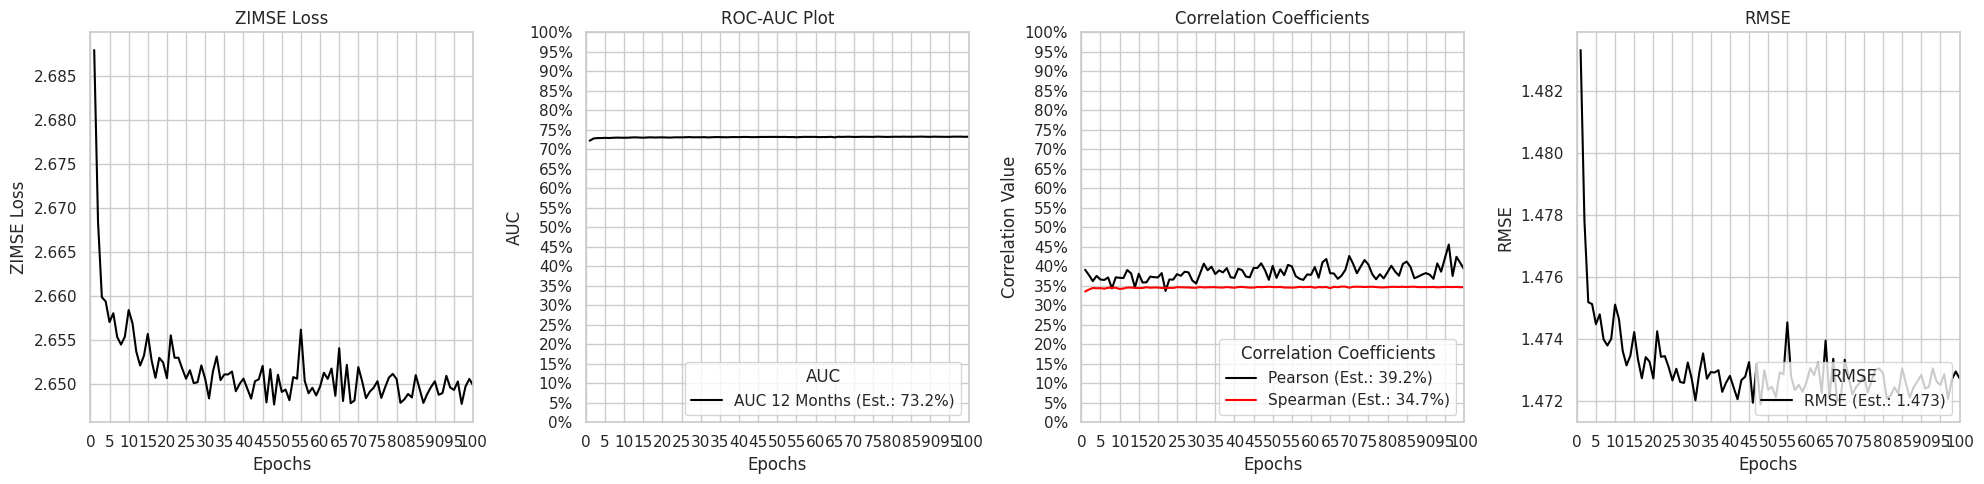

In [150]:
# Creating the first CDF plot
plt.figure(figsize=(20, 5))  # Set the figure size

###################################################################################
plt.subplot(141)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['test']['epoch'], y=results['test']['loss'], color="black")
#sns.lineplot(x=X_pred_2[:,0], y=y_pred_2[:,0], color="red", label=f"Average P(No Purchase): {np.round(100*p_churn,2)}%")
#plt.legend(loc='upper right', ncol=1, title=u"Sub-Categories")
plt.xlabel('Epochs')
plt.ylabel('ZIMSE Loss')
plt.title('ZIMSE Loss')

plt.xlim([0, 100])
plt.xticks(ticks=[0 + i*5 for i in range(21)])

###################################################################################
plt.subplot(142)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['test']['epoch'], y=results['test']['auc'], color="black", label=f"AUC 12 Months (Est.: {np.round(100*results['test']['auc'][-1],1)}%)")
plt.legend(loc='lower right', ncol=1, title=u"AUC")
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('ROC-AUC Plot')

plt.xlim([0, 100])
plt.xticks(ticks=[0 + i*5 for i in range(21)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

###################################################################################
plt.subplot(143)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['test']['epoch'], y=results['test']['pearsonr'], color="black", label=f"Pearson (Est.: {np.round(100*results['test']['pearsonr'][-1],1)}%)")
sns.lineplot(x=results['test']['epoch'], y=results['test']['spearmanr'], color="red", label=f"Spearman (Est.: {np.round(100*results['test']['spearmanr'][-1],1)}%)")
plt.legend(loc='lower right', ncol=1, title=u"Correlation Coefficients")
plt.xlabel('Epochs')
plt.ylabel("Correlation Value")
plt.title('Correlation Coefficients')

plt.xlim([0, 100])
plt.xticks(ticks=[0 + i*5 for i in range(21)])

plt.ylim([0, 1])
plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

###################################################################################
plt.subplot(144)  # Create a subplot on the left
sns.set(style="whitegrid")

sns.lineplot(x=results['test']['epoch'], y=results['test']['rmse'], color="black", label=f"RMSE (Est.: {np.round(results['test']['rmse'][-1],3)})")
plt.legend(loc='lower right', ncol=1, title=u"RMSE")
plt.xlabel('Epochs')
plt.ylabel("RMSE")
plt.title('RMSE')

plt.xlim([0, 100])
plt.xticks(ticks=[0 + i*5 for i in range(21)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])


# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()
